<center>
    
# Embedding our images as point clouds

## 1 - Modules

In [1]:
# General
import sys
import numpy as np
sys.path.append('code/')

# Torch
import torch
from torch.utils.data import DataLoader

# Personal
from data import ImageTriplet
from model import SiameseNet, SinkhornDivergenceLoss

# Plot
import matplotlib.pyplot as plt
%matplotlib inline

device = 'cuda'

## 2 - Data & Model

In [2]:
notMNIST = ImageTriplet(data='small')

loader = DataLoader(dataset=notMNIST,
                    shuffle=True,
                    batch_size=16,
                    num_workers=8)
for image, positive_sample, negative_sample in loader:
    image = image.to(device)
    positive_sample = positive_sample.to(device)
    negative_sample = negative_sample.to(device)
    
    break
    
net_2D = SiameseNet(100).to(device)
net_2D.load_state_dict(torch.load('models/point_cloud_embedding_2D_M10.model'))


distance = SinkhornDivergenceLoss(lbda=0.1, max_iter=100, p=2, reduction='none')

## 3 - Computing embedding and distance

In [3]:
out = net_2D(image)
positive_sample_out = net_2D(positive_sample)
negative_sample_out = net_2D(negative_sample)

image_point_clouds_t = out.reshape(-1, 32, 2)
positive_sample_point_clouds_t = positive_sample_out.reshape(-1, 32, 2)
negative_sample_point_clouds_t = negative_sample_out.reshape(-1, 32, 2)

positive_2D = distance(image_point_clouds_t, positive_sample_point_clouds_t)
negative_2D = distance(image_point_clouds_t, negative_sample_point_clouds_t)

## 4 - Displaying some triplets

2D POINT CLOUDS:
Positive sample Sinkhorn Divergence: 2.174
Negative sample Sinkhorn Divergence: 8.131
Ratio: 3.7


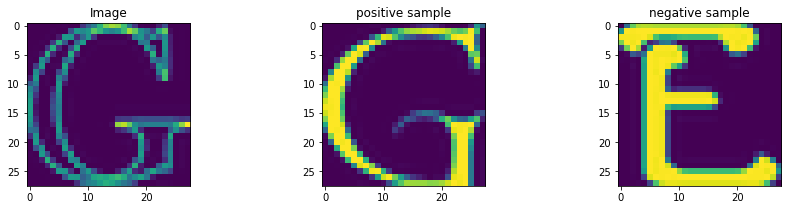

---------------------------------------------------------------------------------------------
2D POINT CLOUDS:
Positive sample Sinkhorn Divergence: 0.099
Negative sample Sinkhorn Divergence: 11.066
Ratio: 111.6


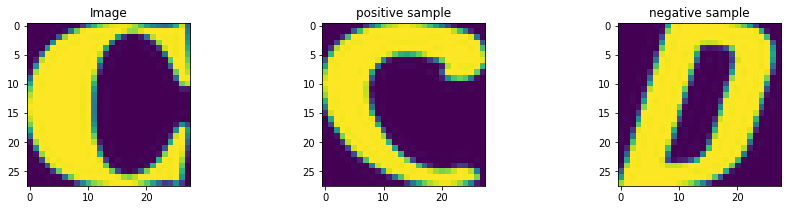

---------------------------------------------------------------------------------------------
2D POINT CLOUDS:
Positive sample Sinkhorn Divergence: 1.860
Negative sample Sinkhorn Divergence: 9.388
Ratio: 5.0


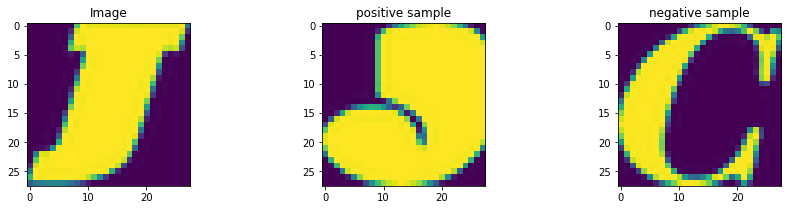

---------------------------------------------------------------------------------------------
2D POINT CLOUDS:
Positive sample Sinkhorn Divergence: 0.165
Negative sample Sinkhorn Divergence: 11.231
Ratio: 68.3


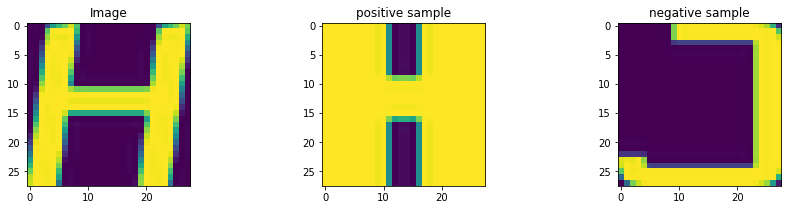

---------------------------------------------------------------------------------------------
2D POINT CLOUDS:
Positive sample Sinkhorn Divergence: 0.417
Negative sample Sinkhorn Divergence: 10.129
Ratio: 24.3


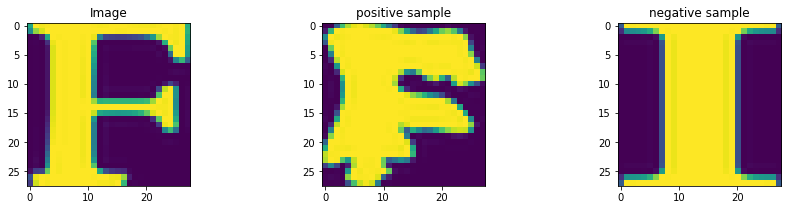

---------------------------------------------------------------------------------------------


In [4]:
for idx in range(5):
    
    print('2D POINT CLOUDS:')
    print('Positive sample Sinkhorn Divergence: %.3f' % positive_2D[idx])
    print('Negative sample Sinkhorn Divergence: %.3f' % negative_2D[idx])
    print('Ratio: %.1f' % (negative_2D[idx] / positive_2D[idx]))
    
    fig = plt.figure(figsize=(15, 3))

    plt.subplot(1, 3, 1)
    plt.imshow(image[idx].squeeze(0).cpu())
    plt.title('Image')

    plt.subplot(1, 3, 2)
    plt.imshow(positive_sample[idx].squeeze(0).cpu())
    plt.title('positive sample')

    plt.subplot(1, 3, 3)
    plt.imshow(negative_sample[idx].squeeze(0).cpu())
    plt.title('negative sample')
    
    plt.show()
    
    print('---------------------------------------------------------------------------------------------')

## 5 - Nearest Neighbors

### Randomly choosing a sample from each letter

In [5]:
random_idx = [np.random.randint(0 + 1000 * i, 1000 * (i + 1)) for i in range(10)]
random_idx

[319, 1985, 2761, 3350, 4780, 5230, 6299, 7243, 8215, 9100]

### Computind Sinkhorn Divergence & finding nearest neighbors

In [6]:
letter_list = [l for l in notMNIST.data_dict.values()]

images = np.concatenate(letter_list)
images = torch.FloatTensor(images).unsqueeze(1).to(device)
images.size()

torch.Size([10000, 1, 28, 28])

In [7]:
embeddings = net_2D(images).reshape(-1, 32, 2)
embeddings.size()

torch.Size([10000, 32, 2])

In [8]:
distances, indices = [], []

for sample in random_idx:
    target = embeddings[sample].unsqueeze(0).expand_as(embeddings)
    dist = distance(embeddings, target)
    dist, indice = dist.sort(descending=False)
    dist, indice = dist[1:11], indice[1:11]
    
    distances.append(dist.detach().cpu().numpy())
    indices.append(indice.detach().cpu().numpy())

In [9]:
random_idx

[319, 1985, 2761, 3350, 4780, 5230, 6299, 7243, 8215, 9100]

### Displaying results

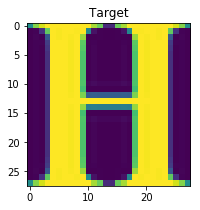

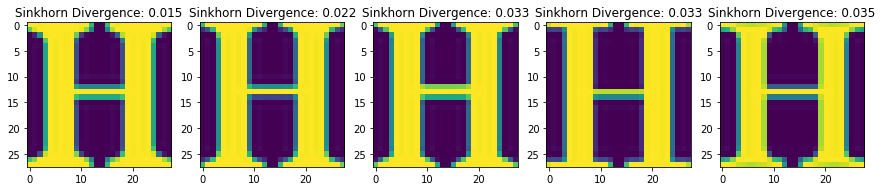

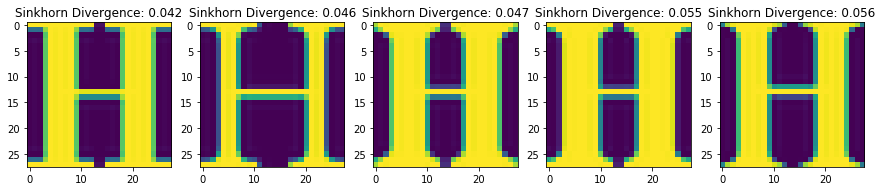

---------------------------------------------------------------------------------------------


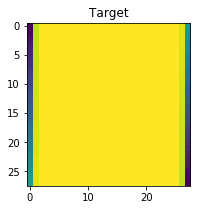

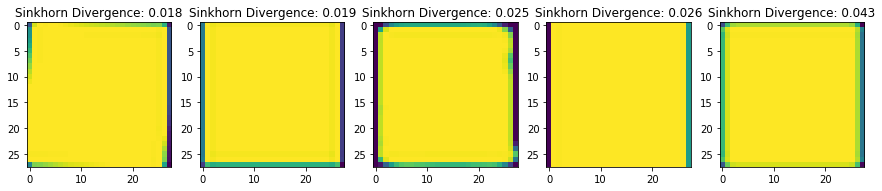

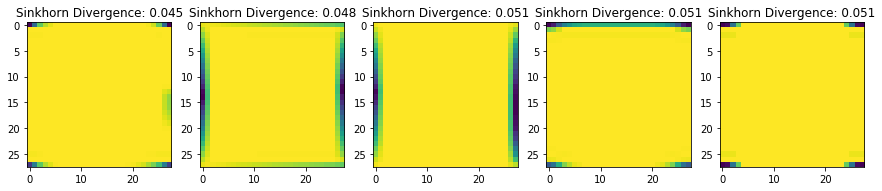

---------------------------------------------------------------------------------------------


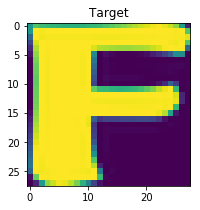

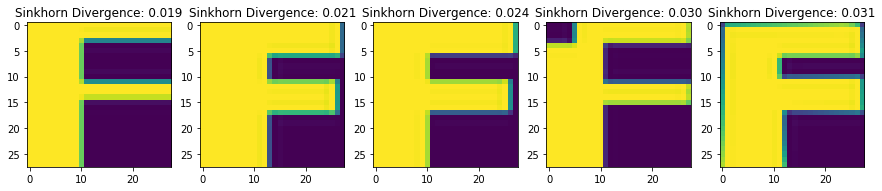

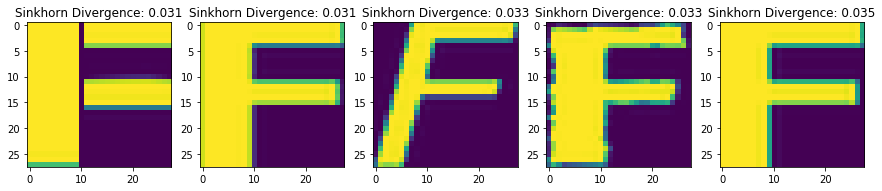

---------------------------------------------------------------------------------------------


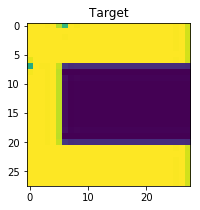

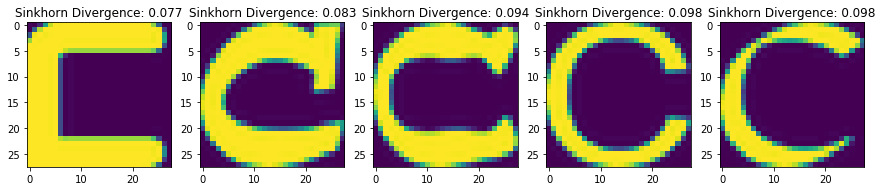

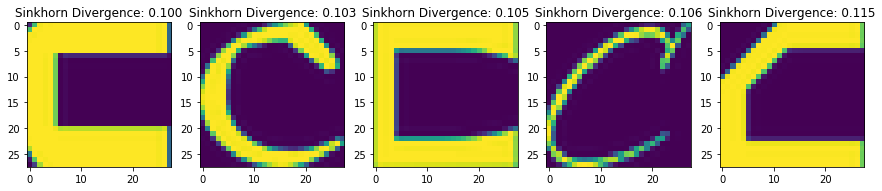

---------------------------------------------------------------------------------------------


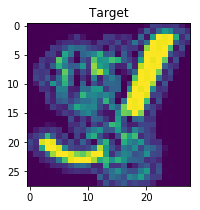

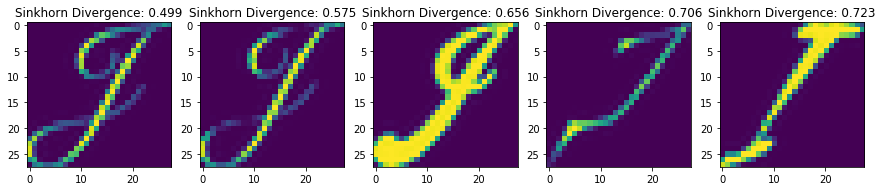

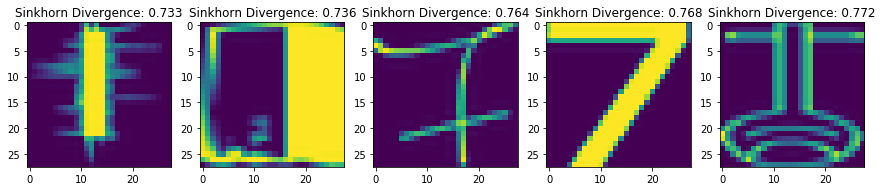

---------------------------------------------------------------------------------------------


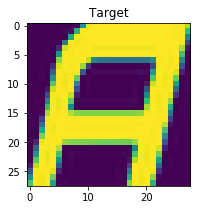

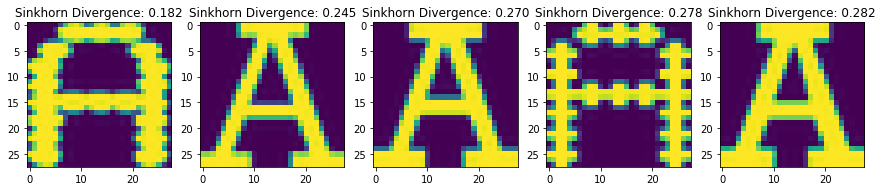

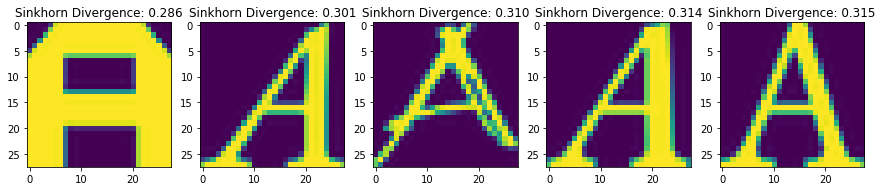

---------------------------------------------------------------------------------------------


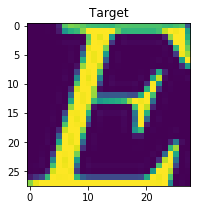

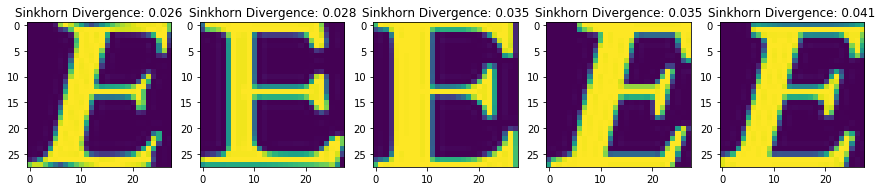

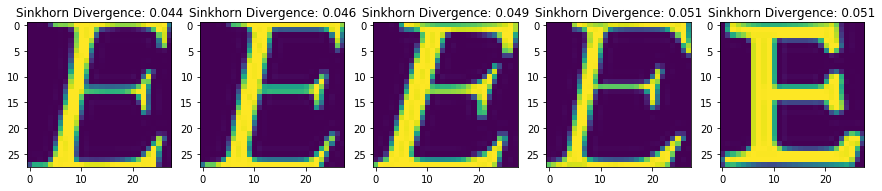

---------------------------------------------------------------------------------------------


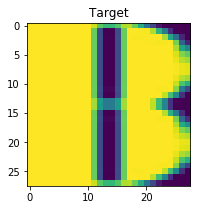

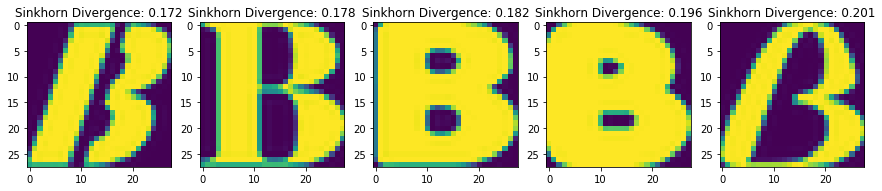

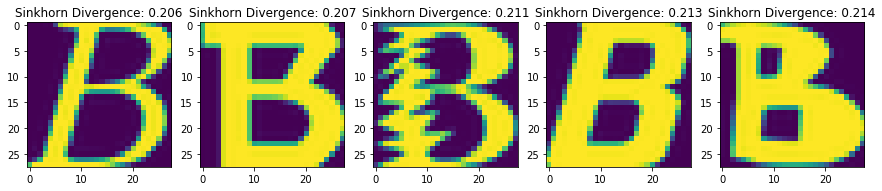

---------------------------------------------------------------------------------------------


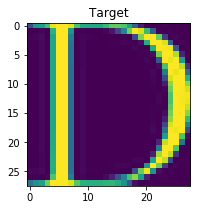

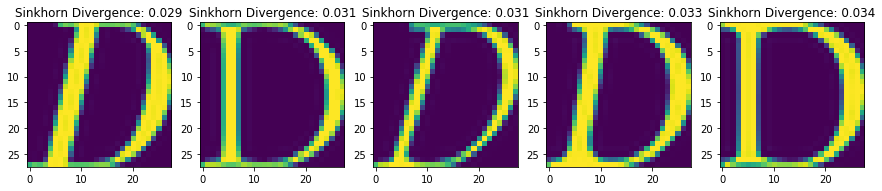

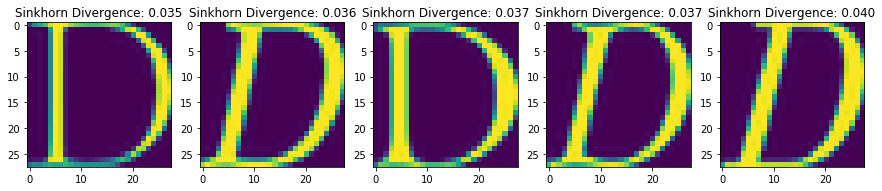

---------------------------------------------------------------------------------------------


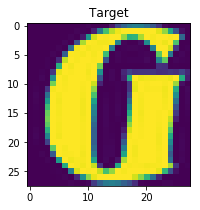

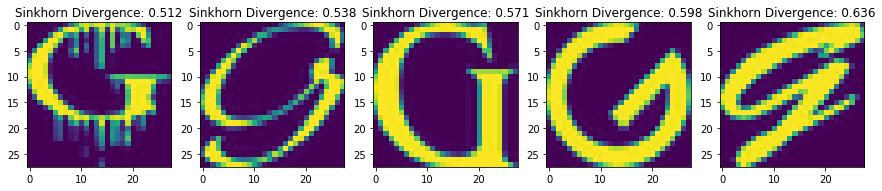

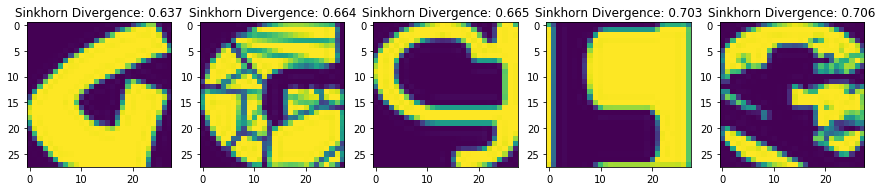

---------------------------------------------------------------------------------------------


In [10]:
for i, sample in enumerate(random_idx):
    
    fig = plt.figure(figsize=(15, 3))
    plt.subplot(1, 1, 1)
    plt.imshow(images[sample].squeeze(0).cpu())
    plt.title('Target')
    plt.show()
    
    fig = plt.figure(figsize=(15, 3))
    for j in range(5):
        
        plt.subplot(1, 5, j + 1)
        plt.imshow(images[indices[i][j]].squeeze(0).cpu())
        plt.title('Sinkhorn Divergence: %.3f' % (distances[i][j]))
        
    plt.show()
        
    fig = plt.figure(figsize=(15, 3))
    for j in range(5, 10):
        
        plt.subplot(1, 5, j-4)
        plt.imshow(images[indices[i][j]].squeeze(0).cpu())
        plt.title('Sinkhorn Divergence: %.3f' % (distances[i][j]))
    
    plt.show()
    
    print('---------------------------------------------------------------------------------------------')